# Moment that we have all been wating for: KANs

Let us firstly rewrite the function fitting to pyTorch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [4]:
def basis_function(i, p, t, x):
    if p == 0:  # Base case: degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), 1.0, 0.0)
    else:
        # Recursive definition with torch operations
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else 0.0

        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else 0.0

        return left + right

Knot vector: [-1.         -1.         -1.         -1.         -0.84615385 -0.69230769
 -0.53846154 -0.38461538 -0.23076923 -0.07692308  0.07692308  0.23076923
  0.38461538  0.53846154  0.69230769  0.84615385  1.          1.
  1.          1.        ]
Coefficients: tensor([[ 0.0578],
        [-0.7640],
        [-1.6715],
        [ 1.2460],
        [ 0.9517],
        [-1.9855],
        [ 0.4796],
        [ 1.5973],
        [-1.5186],
        [-0.4322],
        [ 1.8295],
        [-0.7657],
        [-1.4640],
        [ 2.1510]])


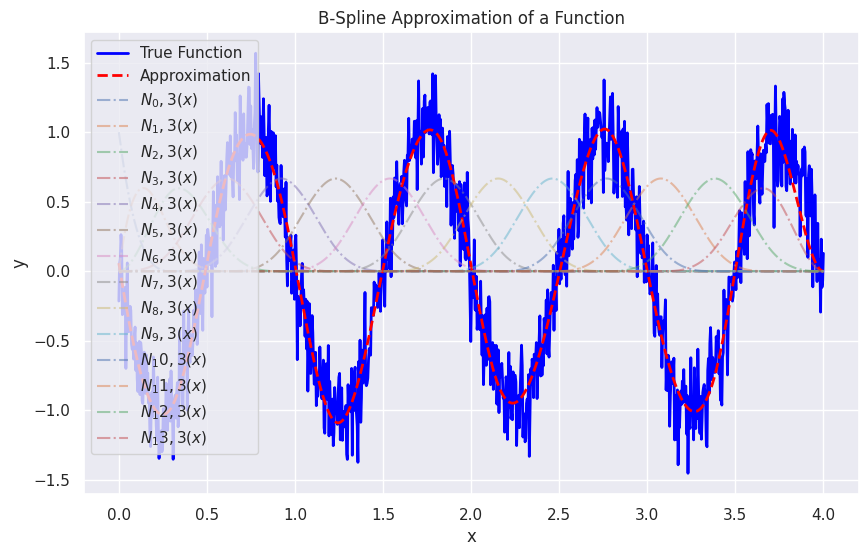

In [76]:
n_control_points = 14
k = 3
t = np.linspace(-1, 1, num=n_control_points)
t = np.pad(t, (k, k), mode='edge')
t_values = np.linspace(t[0], t[-1], 1000)

x_values = torch.linspace(0, 4, 1000)
t_tensor = torch.tensor(t, dtype=torch.float32)
t_values_tensor = torch.tensor(t_values, dtype=torch.float32)

print("Knot vector:", t)

# Precompute basis functions
bfs = torch.zeros((len(t_values), n_control_points), dtype=torch.float32)
for i in range(n_control_points):
    bfs[:, i] = basis_function(i, k, t_tensor, t_values_tensor)

# Function to approximate
fn = lambda x: torch.sin(-2 * np.pi * x) + torch.normal(0, 0.2, x.size())
fn_values = fn(x_values)


# Solve for coefficients using lstsq
coeffs = torch.linalg.lstsq(bfs, fn_values.unsqueeze(1))
coeffs = coeffs.solution
print("Coefficients:", coeffs)

# Compute predicted values
y_pred = torch.matmul(bfs, coeffs)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
for i in range(bfs.shape[1]):
    plt.plot(x_values.numpy(), bfs[:, i].numpy(), label=f'$N_{i},{k}(x)$', linestyle='-.', alpha=0.5)
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
x_values = torch.linspace(0, 4, steps=1000)
fn_values = torch.sin(2 * torch.pi * x_values)


In [ ]:
def basis_function(i, p, t, x):
    if p == 0:
        # Degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), torch.ones_like(x), torch.zeros_like(x))
    else:
        # Recursive definition
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else torch.zeros_like(x)
        
        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else torch.zeros_like(x)
        
        return left + right

In [ ]:
class BSplineLayer(nn.Module):
    def __init__(self, degree, n_control_points):
        super(BSplineLayer, self).__init__()
        self.degree = degree
        self.n_control_points = n_control_points
        self.num_basis = n_control_points
        self.weights = nn.Parameter(torch.randn(self.num_basis))  # Trainable weights
        self.prepare_knots()

    def prepare_knots(self):
        knot_vector = np.linspace(-1, 1, num=self.n_control_points) 
        knot_vector = np.pad(knot_vector, (self.degree, self.degree), mode='edge')
        self.knot_vector = torch.tensor(knot_vector, dtype=torch.float32)
        self.knot_vector.requires_grad = False

    def prepare_bases(self, x_size):
        N = []
        for i in range(self.num_basis):
            N_i = basis_function(i, self.degree, self.knot_vector, torch.linspace(-1, 1, steps=x_size))
            N.append(N_i)
        self.N = torch.stack(N, dim=1)


    def forward(self, x):
        # Compute basis functions
        self.prepare_bases(x.size(0))
        output = self.N @ self.weights 
        return output + x
    

class BSplineNet(nn.Module):
    def __init__(self, n_layers):
        super(BSplineNet, self).__init__()
        self.layers = nn.ModuleList([BSplineLayer(degree=3, n_control_points=14) for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def plot_basis_functions_per_layer(self):
        for idx, layer in enumerate(self.layers):
            # Ensure the bases are prepared (you might need to adjust x_size)
            x_size = 100  # or any appropriate number
            layer.prepare_bases(x_size)
            x_values = torch.linspace(-1, 1, steps=x_size)
            
            plt.figure(figsize=(10, 6))
            for j in range(layer.num_basis):
                print(layer.N.shape, "N", idx, j)
                print(layer.weights.shape, "w", idx, j)
                plt.plot(x_values.numpy(),  layer.N[:, j].detach().numpy() * layer.weights[j].detach().numpy(), 
                         label=f'$N_{{{j}}},3(x)$', linestyle='-.', alpha=0.5)
            plt.xlabel("x")
            plt.ylabel("y")
            plt.legend()
            plt.grid(True)
            plt.show()


Epoch [100/200], Loss: 1.409916
Epoch [200/200], Loss: 0.912326
Num basis 14
torch.Size([100, 14]) N 0 0
torch.Size([14]) w 0 0
torch.Size([100, 14]) N 0 1
torch.Size([14]) w 0 1
torch.Size([100, 14]) N 0 2
torch.Size([14]) w 0 2
torch.Size([100, 14]) N 0 3
torch.Size([14]) w 0 3
torch.Size([100, 14]) N 0 4
torch.Size([14]) w 0 4
torch.Size([100, 14]) N 0 5
torch.Size([14]) w 0 5
torch.Size([100, 14]) N 0 6
torch.Size([14]) w 0 6
torch.Size([100, 14]) N 0 7
torch.Size([14]) w 0 7
torch.Size([100, 14]) N 0 8
torch.Size([14]) w 0 8
torch.Size([100, 14]) N 0 9
torch.Size([14]) w 0 9
torch.Size([100, 14]) N 0 10
torch.Size([14]) w 0 10
torch.Size([100, 14]) N 0 11
torch.Size([14]) w 0 11
torch.Size([100, 14]) N 0 12
torch.Size([14]) w 0 12
torch.Size([100, 14]) N 0 13
torch.Size([14]) w 0 13


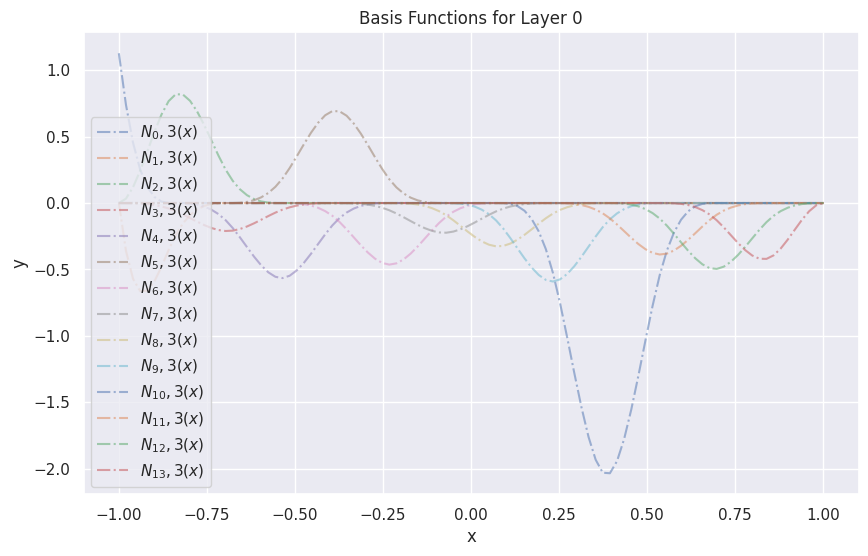

Num basis 14
torch.Size([100, 14]) N 1 0
torch.Size([14]) w 1 0
torch.Size([100, 14]) N 1 1
torch.Size([14]) w 1 1
torch.Size([100, 14]) N 1 2
torch.Size([14]) w 1 2
torch.Size([100, 14]) N 1 3
torch.Size([14]) w 1 3
torch.Size([100, 14]) N 1 4
torch.Size([14]) w 1 4
torch.Size([100, 14]) N 1 5
torch.Size([14]) w 1 5
torch.Size([100, 14]) N 1 6
torch.Size([14]) w 1 6
torch.Size([100, 14]) N 1 7
torch.Size([14]) w 1 7
torch.Size([100, 14]) N 1 8
torch.Size([14]) w 1 8
torch.Size([100, 14]) N 1 9
torch.Size([14]) w 1 9
torch.Size([100, 14]) N 1 10
torch.Size([14]) w 1 10
torch.Size([100, 14]) N 1 11
torch.Size([14]) w 1 11
torch.Size([100, 14]) N 1 12
torch.Size([14]) w 1 12
torch.Size([100, 14]) N 1 13
torch.Size([14]) w 1 13


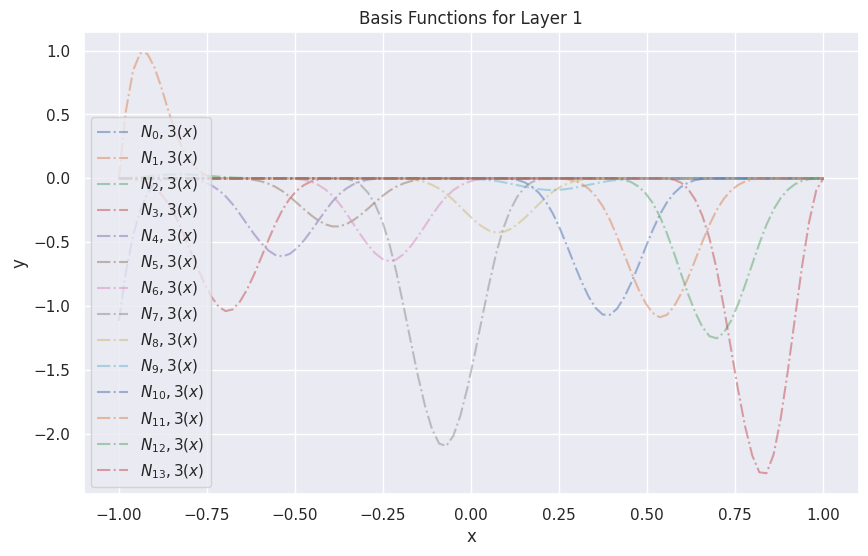

In [129]:
model = BSplineNet(n_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_values)
    loss = criterion(outputs, fn_values)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

model.plot_basis_functions_per_layer()

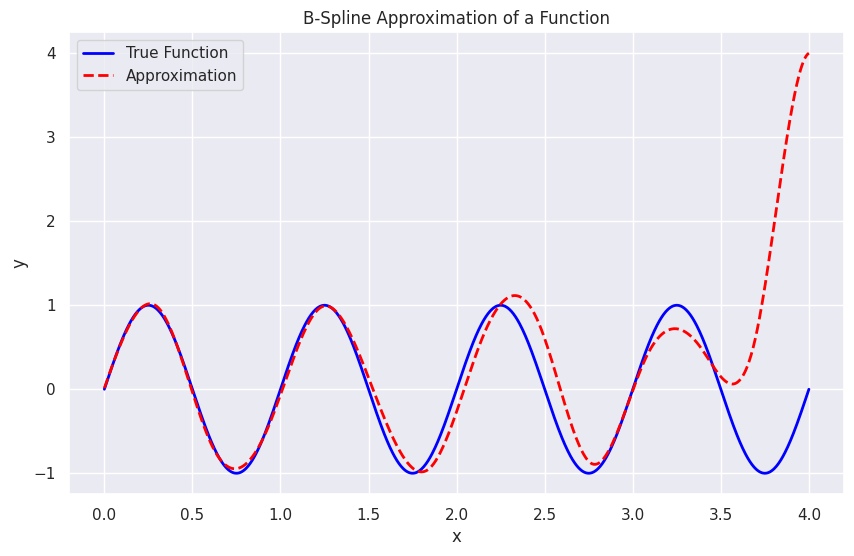

In [130]:
k# Compute predicted values
y_pred = model(x_values).detach()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()